In [91]:
import numpy as np
import pandas as pd
import random
import torch
import dgl
import os
import sys

# 현재 파일의 상위 디렉토리를 sys.path에 추가
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [92]:
# 폰트 설정
import matplotlib as mpl
import matplotlib.font_manager as fm

font_path = r"C:\Windows\Fonts\malgun.ttf"  
font_prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

In [93]:
# 재현성 난수 고정
def SET_SEED():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    dgl.random.seed(SEED)

    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 100
SET_SEED()

In [94]:
dataset = 'freesolv' # freesolv / esol / molproperty_vd / lipo
save_dir = r'..\results_figure'

In [95]:
df = pd.read_csv(r'..\datasets\\' + dataset + '.csv')
smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['CN(C)C(=O)c1ccc(cc1)OC', 'CS(=O)(=O)Cl', 'CC(C)C=C', 'CCc1cnccn1', 'CCCCCCCO']
0   -11.01
1    -4.87
2     1.83
3    -5.45
4    -4.21
Name: freesolv, dtype: float64


In [96]:
from utils.utils import MolecularFeatureExtractor
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features

num_all_features = df_all_features.shape[1] - 1 
print("초기 변수 개수:", num_all_features)

# na handling
# NA 확인
df_all_features[df_all_features.isna().any(axis = 1)] # 행방향

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_all_features.isna().any(axis = 0).sum(), '\n')
print(df_all_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_all_features.isna().any(axis = 1).sum(), '\n')
print(df_all_features.isna().any(axis = 1))

df_removed_features = df_all_features.dropna()

# 결측치가 포함된 feature 제거
# df_removed_features = df_all_features.dropna(axis = 1)
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features)

# 결측치가 제거된 data frame
df_removed_features

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_removed_features.isna().any(axis = 0).sum(), '\n')
print(df_removed_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_removed_features.isna().any(axis = 1).sum(), '\n')
print(df_removed_features.isna().any(axis = 1))



# nunique == 1 인 경우는 제
unique_columns = list(df_removed_features.loc[:, df_removed_features.nunique() == 1].columns)
print('nunique == 1인 feature : \n', unique_columns, '\n')

# nunique == 1인 feature 제거
#df_removed_features.drop(columns = unique_columns, inplace = True)
df_removed_features = df_removed_features.drop(columns = unique_columns).copy()

num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)


# 너무 낮은 vairnace를 가지는 경
low_variances = sorted(df_removed_features.var())
low_variances[:10]

columns_low_variances = []

for i in low_variances:
    if i < 0.001:
        column = df_removed_features.loc[:, df_removed_features.var() == i].columns
        columns_low_variances.append(column)
columns_low_variances = [item for index in columns_low_variances for item in index]

# 2. 중복 제거 및 유니크 값 추출
columns_low_variances = list(set(columns_low_variances))
print(columns_low_variances)

# 낮은 분산의 변수 제거
df_removed_features = df_removed_features.drop(columns = columns_low_variances).reset_index(drop=True).copy()
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)

df_removed_features

초기 변수 개수: 208
결측치가 포함된 열 개수: 0 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 0 

0      False
1      False
2      False
3      False
4      False
       ...  
637    False
638    False
639    False
640    False
641    False
Length: 642, dtype: bool
제거 후 남은 feature 개수: 208
결측치가 포함된 열 개수: 0 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 0 

0      False
1      False
2      False
3      False
4      False
       ..

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_piperzine,fr_priamide,fr_pyridine,fr_sulfide,fr_sulfone,fr_term_acetylene,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,11.429183,0.002457,11.429183,0.002457,0.686360,179.219,166.115,179.094629,70,0.252836,...,0,0,0,0,0,0,0,0,0,-11.01
1,9.397377,-3.194444,9.397377,0.925154,0.421427,114.553,111.529,113.954228,32,0.229212,...,0,0,0,0,0,0,0,0,0,-4.87
2,3.560185,0.648148,3.560185,0.648148,0.412737,70.135,60.055,70.078250,30,-0.029310,...,0,0,0,0,0,0,0,0,0,1.83
3,4.034722,0.966111,4.034722,0.966111,0.536795,108.144,100.080,108.068748,42,0.058343,...,0,0,0,0,0,0,0,0,0,-5.45
4,8.365587,0.364796,8.365587,0.364796,0.544191,116.204,100.076,116.120115,50,0.043052,...,0,0,0,0,0,0,0,3,0,-4.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,10.622272,-0.081946,10.622272,0.081946,0.438315,158.241,140.097,158.130680,66,0.305002,...,0,0,0,0,0,0,0,3,0,-2.04
638,3.222222,1.250000,3.222222,1.250000,0.434794,71.123,62.051,71.073499,30,-0.004845,...,0,0,0,0,0,0,0,0,0,-5.48
639,10.036149,0.181111,10.036149,0.181111,0.568137,122.123,116.075,122.036779,46,0.149553,...,0,0,0,0,0,0,0,0,0,-8.83
640,5.480456,0.837018,5.480456,0.837018,0.400312,134.650,119.530,134.086228,50,0.022296,...,0,0,0,0,0,0,0,3,0,0.29


# tSNE & PCA

In [97]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [98]:
# target split
target = df_removed_features.iloc[:,-1]

# 4등분 / 사분위수 기준으로
Q1, Q2, Q3 = np.percentile(target, [25, 50, 75])
# Q2 = np.percentile(target, 50)
# Q3 = np.percentile(target, 75)
idx_Q1 = np.where(target < Q1)[0]
idx_Q2 = np.where((target >= Q1) & (target < Q2))[0]
idx_Q3 = np.where((target >= Q2) & (target < Q3))[0]
idx_Q4 = np.where(target >= Q3)[0]

# 1/3
med1 = np.percentile(target, 33)
med2 = np.percentile(target, 66)
idx_med4 = np.where(target < med1)[0]
idx_med5 = np.where((target >= med1) & (target < med2))[0]
idx_med6 = np.where(target >= med2)[0]

# 중앙값
med = np.percentile(target, 50)
idx_med1 = np.where(target < med)[0]
idx_med2 = np.where(target >= med)[0]

In [99]:
X = np.array(df_removed_features.drop(columns = ['target']))
X.shape

(642, 177)

In [100]:
perplexity = 30
method = 'barnes_hut' 
# default: barnes_hut, 'exact'

In [101]:
PCA_model2D = PCA(n_components = 2)
PCA_model3D = PCA(n_components = 3)

scaler = StandardScaler()

X_scaling = scaler.fit_transform(X)

X_pca2D = PCA_model2D.fit_transform(X_scaling)
X_pca3D = PCA_model3D.fit_transform(X_scaling)

In [102]:
tsne = TSNE(n_components = 2, random_state = SEED, perplexity = perplexity, method = method)
tsne3D = TSNE(n_components = 3, random_state = SEED, perplexity = perplexity, method = method)

# X_tsne = tsne.fit_transform(X)
# X_tsne3D = tsne3D.fit_transform(X)
X_tsne = tsne.fit_transform(X_scaling)
X_tsne3D = tsne3D.fit_transform(X_scaling)

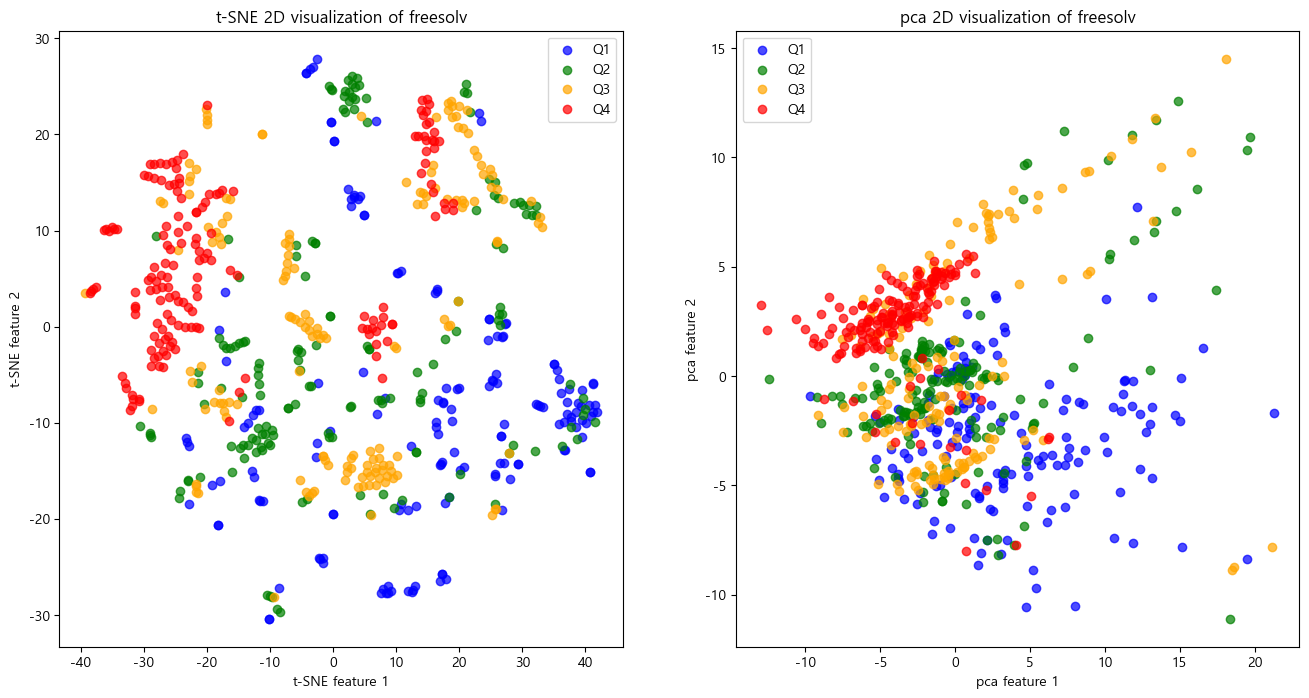

In [103]:
# 4등분 2D

# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)

ax1.scatter(X_tsne[idx_Q1, 0], X_tsne[idx_Q1, 1], label='Q1', c='blue', alpha=0.7)
ax1.scatter(X_tsne[idx_Q2, 0], X_tsne[idx_Q2, 1], label='Q2', c='green', alpha=0.7)
ax1.scatter(X_tsne[idx_Q3, 0], X_tsne[idx_Q3, 1], label='Q3', c='orange', alpha=0.7)
ax1.scatter(X_tsne[idx_Q4, 0], X_tsne[idx_Q4, 1], label='Q4', c='red', alpha=0.7)

ax1.set_title(f't-SNE 2D visualization of {dataset}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.legend()

# PCA
ax2 = fig.add_subplot(122)

ax2.scatter(X_pca2D[idx_Q1, 0], X_pca2D[idx_Q1, 1], label='Q1', c='blue', alpha=0.7)
ax2.scatter(X_pca2D[idx_Q2, 0], X_pca2D[idx_Q2, 1], label='Q2', c='green', alpha=0.7)
ax2.scatter(X_pca2D[idx_Q3, 0], X_pca2D[idx_Q3, 1], label='Q3', c='orange', alpha=0.7)
ax2.scatter(X_pca2D[idx_Q4, 0], X_pca2D[idx_Q4, 1], label='Q4', c='red', alpha=0.7)

ax2.set_title(f'pca 2D visualization of {dataset}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.legend()
plt.show()

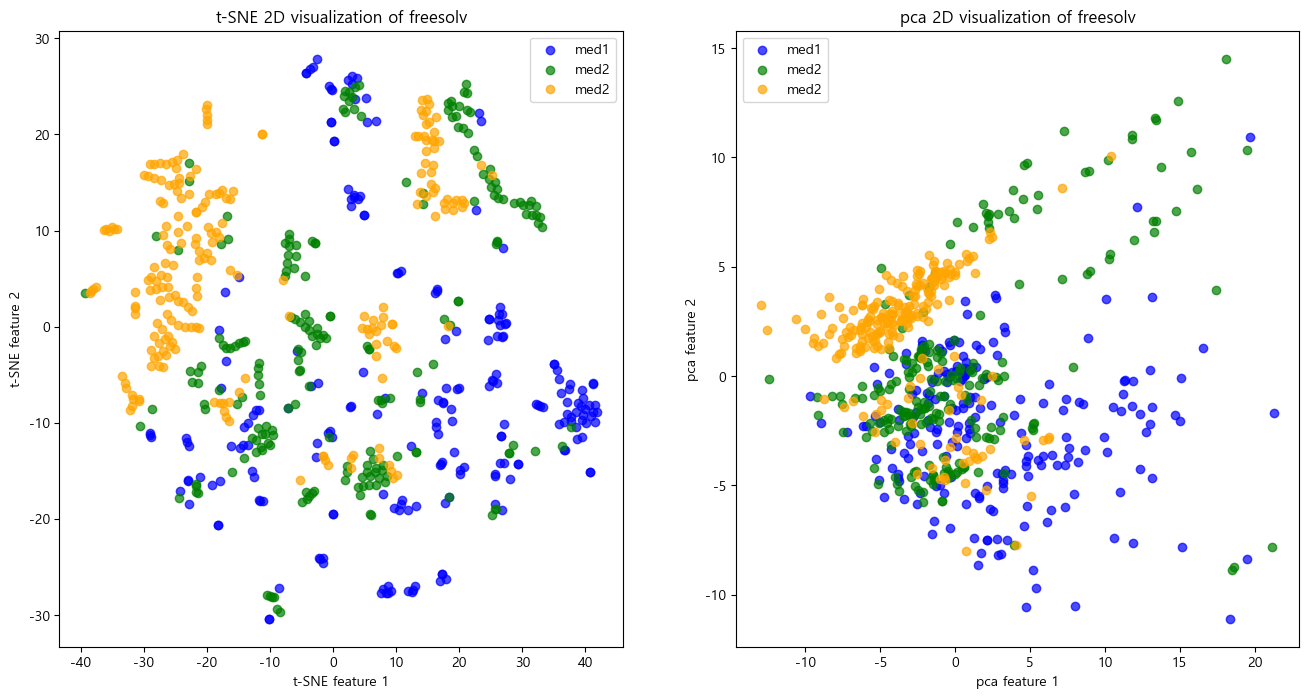

In [104]:
# 3등분 2D

# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)

ax1.scatter(X_tsne[idx_med4, 0], X_tsne[idx_med4, 1], label='med1', c='blue', alpha=0.7)
ax1.scatter(X_tsne[idx_med5, 0], X_tsne[idx_med5, 1], label='med2', c='green', alpha=0.7)
ax1.scatter(X_tsne[idx_med6, 0], X_tsne[idx_med6, 1], label='med2', c='orange', alpha=0.7)

ax1.set_title(f't-SNE 2D visualization of {dataset}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.legend()

# pca
ax2 = fig.add_subplot(122)

ax2.scatter(X_pca2D[idx_med4, 0], X_pca2D[idx_med4, 1], label='med1', c='blue', alpha=0.7)
ax2.scatter(X_pca2D[idx_med5, 0], X_pca2D[idx_med5, 1], label='med2', c='green', alpha=0.7)
ax2.scatter(X_pca2D[idx_med6, 0], X_pca2D[idx_med6, 1], label='med2', c='orange', alpha=0.7)

ax2.set_title(f'pca 2D visualization of {dataset}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.legend()
plt.show()

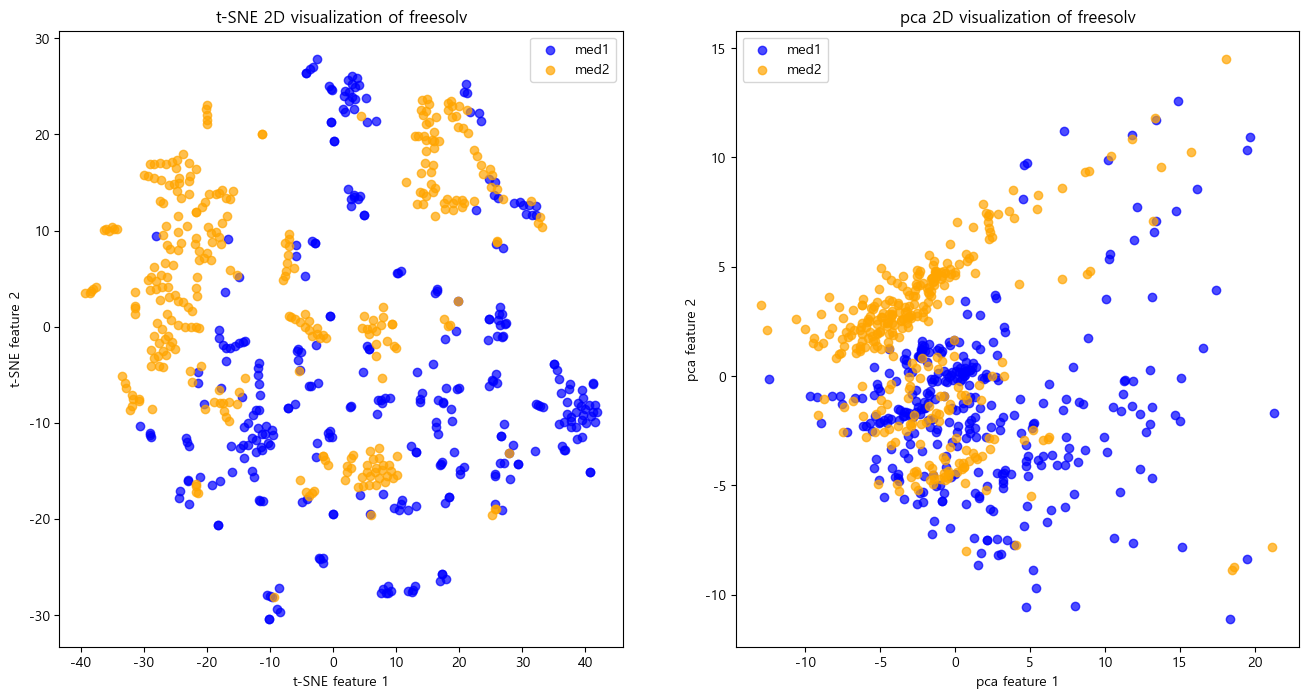

In [105]:
# 2등분 2D

# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)

ax1.scatter(X_tsne[idx_med1, 0], X_tsne[idx_med1, 1], label='med1', c='blue', alpha=0.7)
ax1.scatter(X_tsne[idx_med2, 0], X_tsne[idx_med2, 1], label='med2', c='orange', alpha=0.7)

ax1.set_title(f't-SNE 2D visualization of {dataset}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.legend()

# 시각화
ax2 = fig.add_subplot(122)

ax2.scatter(X_pca2D[idx_med1, 0], X_pca2D[idx_med1, 1], label='med1', c='blue', alpha=0.7)
ax2.scatter(X_pca2D[idx_med2, 0], X_pca2D[idx_med2, 1], label='med2', c='orange', alpha=0.7)

ax2.set_title(f'pca 2D visualization of {dataset}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.legend()
plt.show()

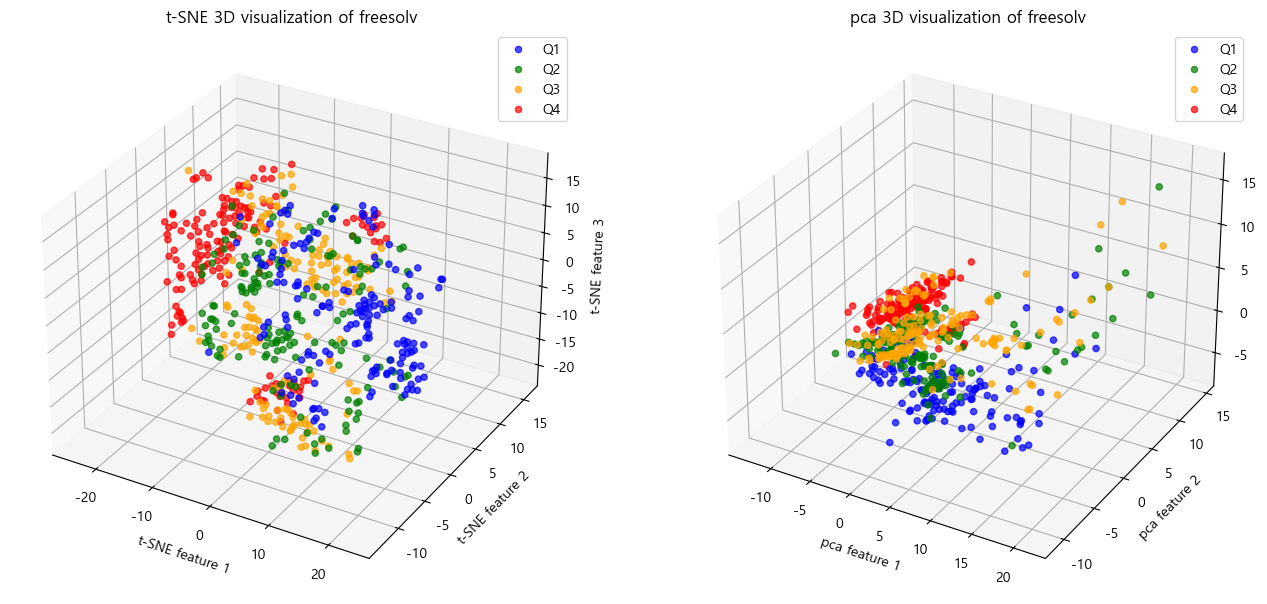

In [106]:
# 4등분 3D

# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')

ax1.scatter(X_tsne3D[idx_Q1, 0], X_tsne3D[idx_Q1, 1], X_tsne3D[idx_Q1, 2], label='Q1', c='blue', alpha=0.7)
ax1.scatter(X_tsne3D[idx_Q2, 0], X_tsne3D[idx_Q2, 1], X_tsne3D[idx_Q2, 2], label='Q2', c='green', alpha=0.7)
ax1.scatter(X_tsne3D[idx_Q3, 0], X_tsne3D[idx_Q3, 1], X_tsne3D[idx_Q3, 2], label='Q3', c='orange', alpha=0.7)
ax1.scatter(X_tsne3D[idx_Q4, 0], X_tsne3D[idx_Q4, 1], X_tsne3D[idx_Q4, 2], label='Q4', c='red', alpha=0.7)

ax1.set_title(f't-SNE 3D visualization of {dataset}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.set_zlabel('t-SNE feature 3')
ax1.legend()

# pca
ax2 = fig.add_subplot(122, projection='3d')

ax2.scatter(X_pca3D[idx_Q1, 0], X_pca3D[idx_Q1, 1], X_pca3D[idx_Q1, 2], label='Q1', c='blue', alpha=0.7)
ax2.scatter(X_pca3D[idx_Q2, 0], X_pca3D[idx_Q2, 1], X_pca3D[idx_Q2, 2], label='Q2', c='green', alpha=0.7)
ax2.scatter(X_pca3D[idx_Q3, 0], X_pca3D[idx_Q3, 1], X_pca3D[idx_Q3, 2], label='Q3', c='orange', alpha=0.7)
ax2.scatter(X_pca3D[idx_Q4, 0], X_pca3D[idx_Q4, 1], X_pca3D[idx_Q4, 2], label='Q4', c='red', alpha=0.7)

ax2.set_title(f'pca 3D visualization of {dataset}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.set_zlabel('pca feature 3')
ax2.legend()
plt.show()

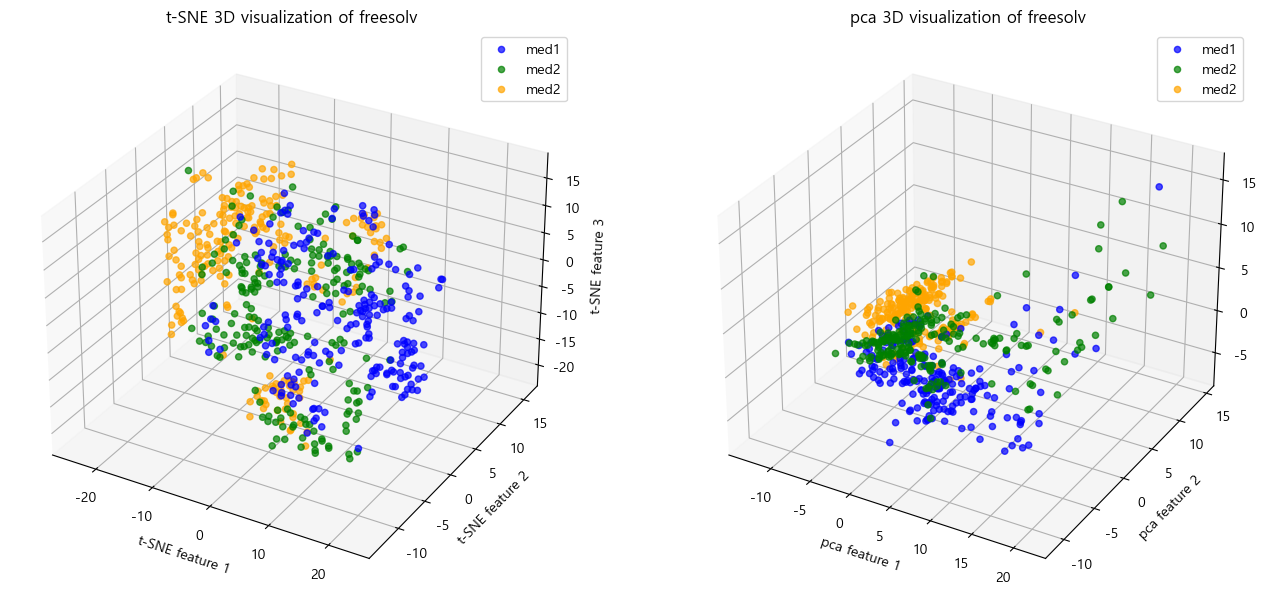

In [107]:
# 3등분 3D

# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')

ax1.scatter(X_tsne3D[idx_med4, 0], X_tsne3D[idx_med4, 1], X_tsne3D[idx_med4, 2], label='med1', c='blue', alpha=0.7)
ax1.scatter(X_tsne3D[idx_med5, 0], X_tsne3D[idx_med5, 1], X_tsne3D[idx_med5, 2], label='med2', c='green', alpha=0.7)
ax1.scatter(X_tsne3D[idx_med6, 0], X_tsne3D[idx_med6, 1], X_tsne3D[idx_med6, 2], label='med2', c='orange', alpha=0.7)

ax1.set_title(f't-SNE 3D visualization of {dataset}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.set_zlabel('t-SNE feature 3')
ax1.legend()

# pca
ax2 = fig.add_subplot(122, projection='3d')

ax2.scatter(X_pca3D[idx_med4, 0], X_pca3D[idx_med4, 1], X_pca3D[idx_med4, 2], label='med1', c='blue', alpha=0.7)
ax2.scatter(X_pca3D[idx_med5, 0], X_pca3D[idx_med5, 1], X_pca3D[idx_med5, 2], label='med2', c='green', alpha=0.7)
ax2.scatter(X_pca3D[idx_med6, 0], X_pca3D[idx_med6, 1], X_pca3D[idx_med6, 2], label='med2', c='orange', alpha=0.7)

ax2.set_title(f'pca 3D visualization of {dataset}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.set_zlabel('pca feature 3')
ax2.legend()
plt.show()

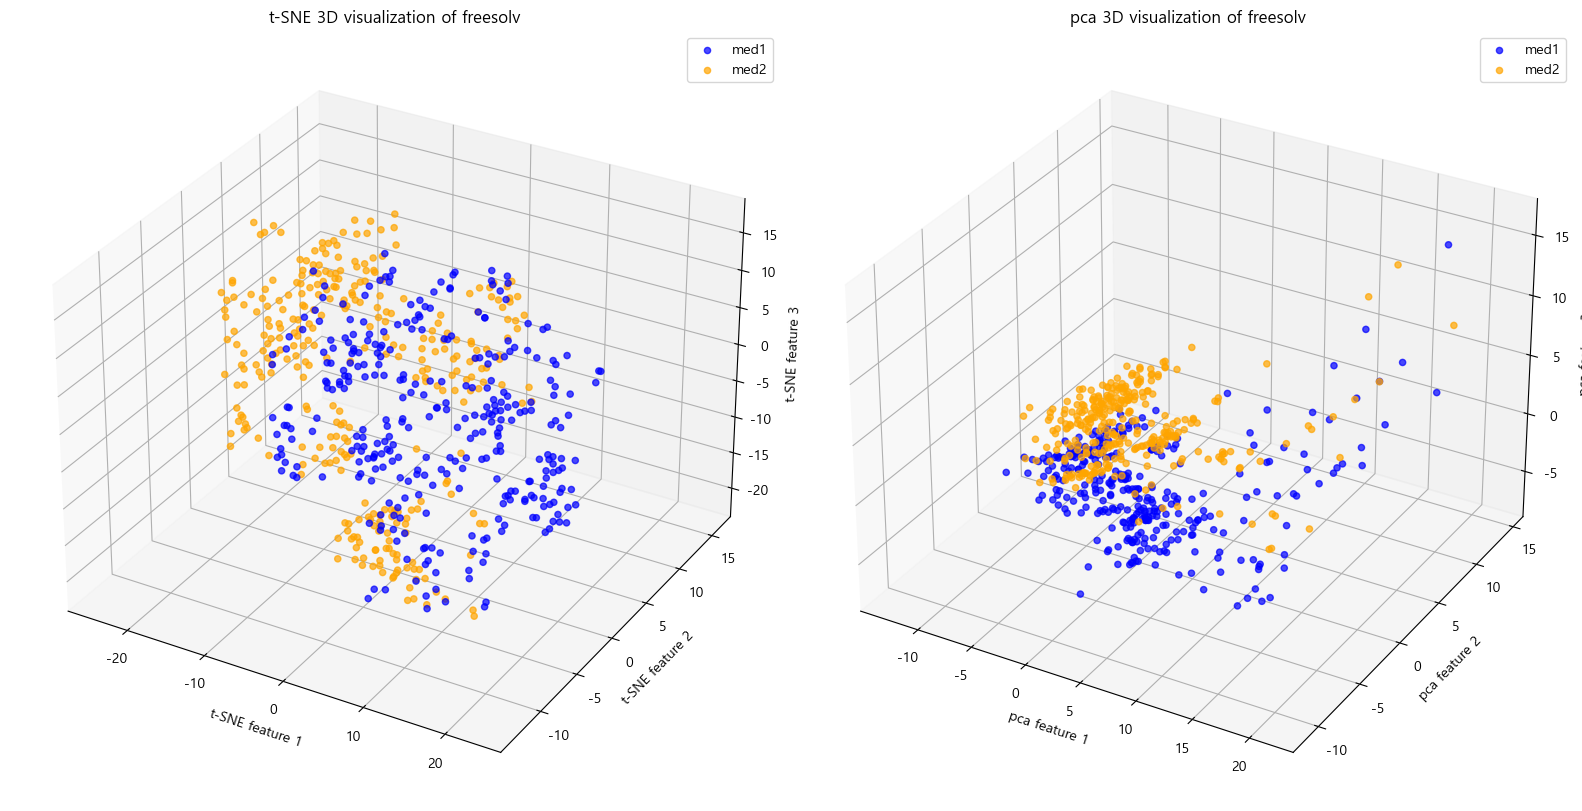

In [108]:
# 2등분 3D

# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')

ax1.scatter(X_tsne3D[idx_med1, 0], X_tsne3D[idx_med1, 1], X_tsne3D[idx_med1, 2], label='med1', c='blue', alpha=0.7)
ax1.scatter(X_tsne3D[idx_med2, 0], X_tsne3D[idx_med2, 1], X_tsne3D[idx_med2, 2], label='med2', c='orange', alpha=0.7)

ax1.set_title(f't-SNE 3D visualization of {dataset}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.set_zlabel('t-SNE feature 3')
ax1.legend()

# pca
ax2 = fig.add_subplot(122, projection='3d')

ax2.scatter(X_pca3D[idx_med1, 0], X_pca3D[idx_med1, 1], X_pca3D[idx_med1, 2], label='med1', c='blue', alpha=0.7)
ax2.scatter(X_pca3D[idx_med2, 0], X_pca3D[idx_med2, 1], X_pca3D[idx_med2, 2], label='med2', c='orange', alpha=0.7)

ax2.set_title(f'pca 3D visualization of {dataset}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.set_zlabel('pca feature 3')
ax2.legend()
plt.tight_layout()
plt.show()